# Homework Setup

### 1. Created Conda Environment
```bash
conda create --name col775 python=3.10
```

### 2. Installed PyTorch with CUDA
```bash
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
```

### 3. Installed Required Packages
```bash
pip3 install numpy matplotlib pandas scikit-learn
```

Packages installed:
- `numpy`: For numerical operations
- `matplotlib`: For visualizations
- `pandas`: For data handling
- `scikit-learn`: For ML utilities
- `pytorch`: For deep learning

## Understanding Logistic Regression

Logistic Regression is a fundamental machine learning algorithm primarily used for **binary classification** tasks. 

### Key Characteristics:
- **Input**: Feature vectors xᵢ ∈ ℝᵐ (m-dimensional real-valued vectors)
- **Output**: Binary labels yᵢ ∈ {0, 1}
- **Prediction**: Produces probability estimates $\hat y$ ∈ [0,1]

### Mathematical Foundation:
The model applies the logistic (sigmoid) function to a linear combination of inputs:

$\hat{y}$= 1 / (1 + e⁻ᶻ)

Where:
- z = wᵀx + b (linear transformation)
- w = weight vector
- b = bias term


This will help to find the $\hat{y}$ but while training we need to update the weights of the given, To encounter this issue there are the objective functions or the Loss functions which will help in the maintaining the weight of the model to make sure that model predictions are generalized and does not lead to overfit or underfit cases.








Test Set Performance Metrics:
Model                Accuracy   Precision  F1 Score  
--------------------------------------------------
Cross-Entropy (L1)   1.0000     1.0000     1.0000    
MSE (L2)             0.8667     0.8182     0.9000    
Modified (L3)        0.6667     0.6429     0.7826    


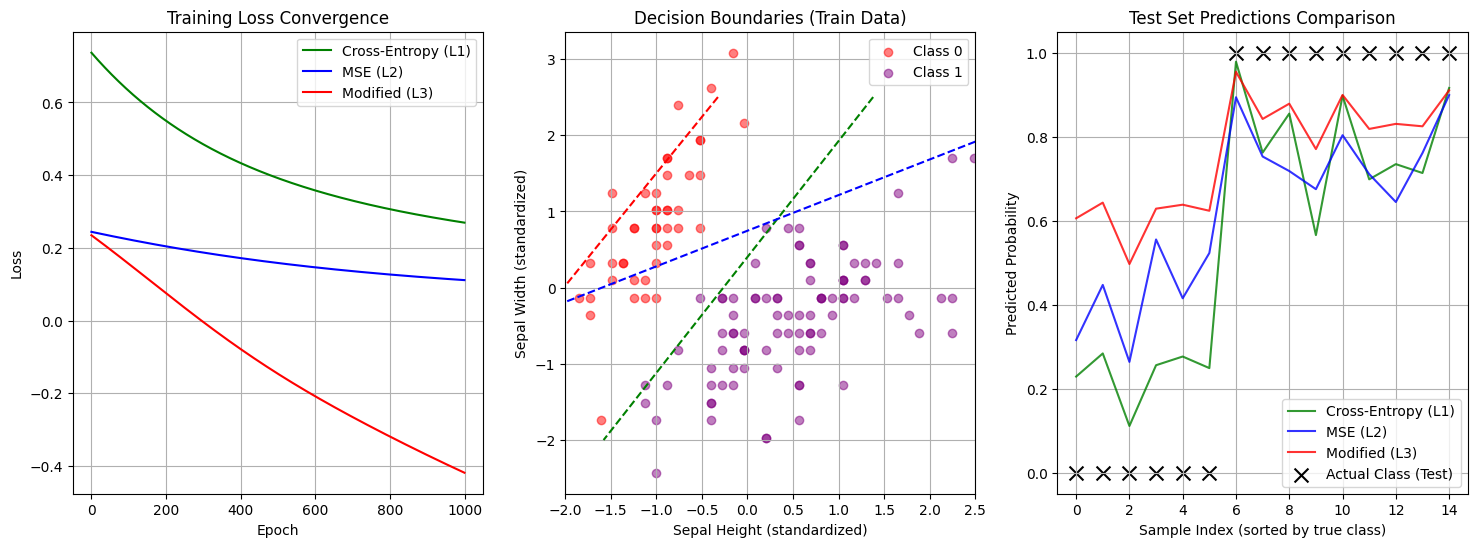

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score
import numpy as np
np.random.seed(0)
torch.random.seed()
# Load and prepare data
iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0).astype(int)

# Split into train (90%) and test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize using training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Custom loss functions
def L1_loss(y_pred, y_true):  # Standard BCE
    return -torch.mean(y_true * torch.log(y_pred) + (1-y_true) * torch.log(1-y_pred))

def L2_loss(y_pred, y_true):  # MSE
    return torch.mean((y_pred - y_true)**2)

def L3_loss(y_pred, y_true):  # Modified logistic
    return -torch.mean((2*(y_true-0.5)) * (2*(y_pred-0.5)))

# Training function
def train_with_loss(loss_fn, loss_name, color):
    model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    loss_history = []
    
    for epoch in range(1000):
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
    
    return model, loss_history

# Train with all three loss functions
models = {}
loss_histories = {}
colors = ['green', 'blue', 'red']
names = ['Cross-Entropy (L1)', 'MSE (L2)', 'Modified (L3)']

for i, (loss_fn, name) in enumerate(zip([L1_loss, L2_loss, L3_loss], names)):
    model, history = train_with_loss(loss_fn, name, colors[i])
    models[name] = model
    loss_histories[name] = history

# Plotting
plt.figure(figsize=(18, 6))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
for name, color in zip(names, colors):
    plt.plot(loss_histories[name], color=color, label=name)
plt.title("Training Loss Convergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot 2: Decision boundaries
plt.subplot(1, 3, 2)
xx, yy = np.meshgrid(np.linspace(-2, 2.5, 100), np.linspace(-2, 2.5, 100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

for name, color in zip(names, colors):
    with torch.no_grad():
        Z = models[name](grid).numpy().reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0.5], colors=color, linestyles='dashed')
plt.scatter(X_train_scaled[y_train==0, 0], X_train_scaled[y_train==0, 1], color='red', label='Class 0', alpha=0.5)
plt.scatter(X_train_scaled[y_train==1, 0], X_train_scaled[y_train==1, 1], color='purple', label='Class 1', alpha=0.5)
plt.title("Decision Boundaries (Train Data)")
plt.xlabel("Sepal Height (standardized)")
plt.ylabel("Sepal Width (standardized)")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
with torch.no_grad():
    test_pred_probs = {name: models[name](X_test_tensor).numpy().flatten() for name in names}
    test_preds = {name: (test_pred_probs[name] > 0.5).astype(int) for name in names}

sort_idx = np.argsort(y_test)

for name, color in zip(names, colors):
    plt.plot(test_pred_probs[name][sort_idx], color=color, label=name, alpha=0.8)

plt.scatter(np.arange(len(y_test)), y_test[sort_idx], 
            color='black', marker='x', s=100, label='Actual Class (Test)')

plt.title("Test Set Predictions Comparison")
plt.xlabel("Sample Index (sorted by true class)")
plt.ylabel("Predicted Probability")
plt.legend()
plt.grid(True)

# Evaluation metrics
print("\nTest Set Performance Metrics:")
print("{:<20} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "F1 Score"))
print("-" * 50)

for name in names:
    y_pred = test_preds[name]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(name, acc, prec, f1))

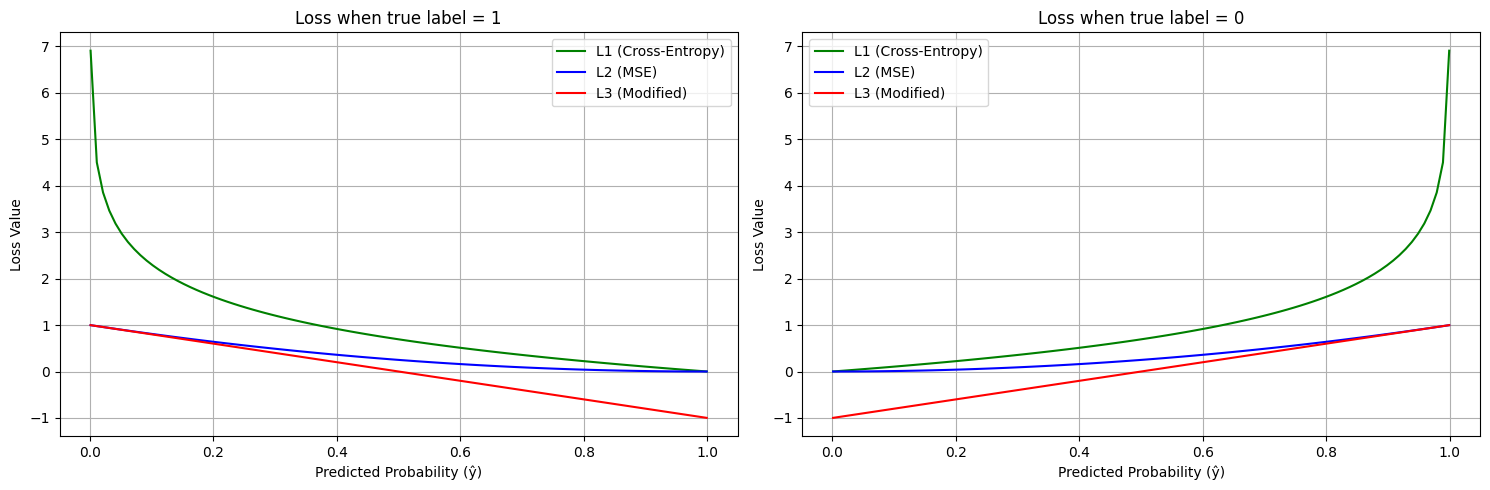

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate predicted probabilities
y_hat = np.linspace(0.001, 0.999, 100)

# True labels (0 and 1 cases)
y_true_0 = np.zeros_like(y_hat)
y_true_1 = np.ones_like(y_hat)

# Define loss functions
def L1(y_hat, y):  # Cross-Entropy
    return - (y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

def L2(y_hat, y):  # MSE
    return (y_hat - y)**2

def L3(y_hat, y):  # Modified
    return - (2*(y-0.5)) * (2*(y_hat-0.5))

# Create figure
plt.figure(figsize=(15, 5))

# Plot for true label = 1
plt.subplot(1, 2, 1)
plt.plot(y_hat, L1(y_hat, y_true_1), 'g-', label='L1 (Cross-Entropy)')
plt.plot(y_hat, L2(y_hat, y_true_1), 'b-', label='L2 (MSE)')
plt.plot(y_hat, L3(y_hat, y_true_1), 'r-', label='L3 (Modified)')
plt.title("Loss when true label = 1")
plt.xlabel("Predicted Probability (ŷ)")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)

# Plot for true label = 0
plt.subplot(1, 2, 2)
plt.plot(y_hat, L1(y_hat, y_true_0), 'g-', label='L1 (Cross-Entropy)')
plt.plot(y_hat, L2(y_hat, y_true_0), 'b-', label='L2 (MSE)')
plt.plot(y_hat, L3(y_hat, y_true_0), 'r-', label='L3 (Modified)')
plt.title("Loss when true label = 0")
plt.xlabel("Predicted Probability (ŷ)")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()